In [144]:
from datetime import datetime as dt
from datetime import timedelta
import json
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator
import pandas
import requests

# Set-up to have matplotlib use its support for notebook inline plots
%matplotlib inline

In [2]:
historical_url="https://api.openaq.org/beta/averages"
recent_url="https://api.openaq.org/v1/measurements"
city="Seattle-Tacoma-Bellevue"
location="Seattle-South Park"
temporal="day"
parameter="pm25"

In [4]:
# &parameter=pm25 doesn't seem to work (get a 400)
historical_response = requests.get(f"{historical_url}?location={location}&temporal={temporal}&limit=10000")

In [5]:
meta = json.loads(historical_response.content)['meta']
meta

{'name': 'openaq-api',
 'license': 'CC BY 4.0',
 'website': 'https://docs.openaq.org/',
 'page': 1,
 'limit': 10000,
 'found': 1}

In [6]:
historical_data = json.loads(historical_response.content)["results"]
len(historical_data)

1538

In [7]:
aq_df_hist = pandas.DataFrame.from_dict(historical_data)

In [8]:
aq_df_hist['date'] = aq_df_hist['date'].astype('datetime64[ns]')

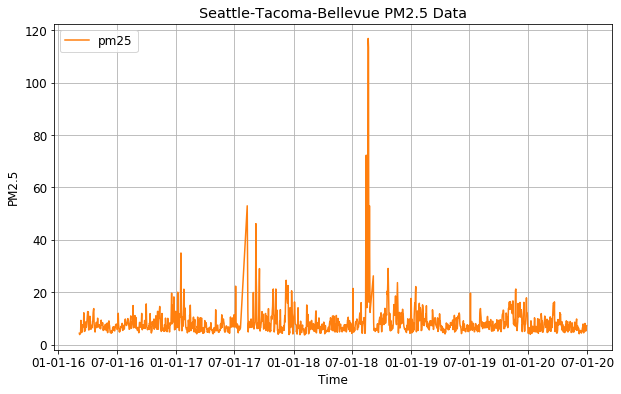

In [9]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(aq_df_hist.date, aq_df_hist.average, color='tab:orange', label='pm25')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('PM2.5')
ax.set_title(f"{city} PM2.5 Data")
ax.grid(True)
ax.legend(loc='upper left')
ax.xaxis.set_major_formatter(DateFormatter('%m-%d-%y'))

In [10]:
recent_response = requests.get(f"{recent_url}?location={location}&parameter={parameter}&limit=10000")

In [11]:
#recent_response.text
meta = json.loads(recent_response.content)['meta']
meta

{'name': 'openaq-api',
 'license': 'CC BY 4.0',
 'website': 'https://docs.openaq.org/',
 'page': 1,
 'limit': 10000,
 'found': 32950}

In [12]:
recent_data = json.loads(recent_response.content)["results"]
len(recent_data)

10000

In [14]:
aq_df_recent = pandas.DataFrame.from_dict(recent_data)

In [16]:
dformat = '%Y-%m-%dT%H:%M:%SZ'
aq_df_recent['datetime'] = [dt.strptime(d['utc'], dformat) for d in aq_df_recent['date'][:]]

In [33]:
aq_df_recent_sampled = aq_df_recent.resample('D', on='datetime').mean()

In [149]:
print("Min / max of API data")
print(aq_df_recent_sampled.index.min())
print(aq_df_recent_sampled.index.max())

print("Min / max of Historical data")
print(aq_df_hist['date'].min())
print(aq_df_hist['date'].max())

# Use API data to fill in recent gaps
most_recent_historical = aq_df_hist['date'].max() + timedelta(days=1)
recent_data = aq_df_recent_sampled[most_recent_historical:aq_df_recent_sampled.index.max()]

#recent_data
data = aq_df_hist['average'].astype('float64')
dates = aq_df_hist['date']
hist_series = pandas.Series(data, index=dates, name='average', dtype=float)
hist_series[:] = data

Min / max of API data
2019-06-21 00:00:00
2020-09-20 00:00:00
Min / max of Historical data
2016-03-06 00:00:00
2020-06-30 00:00:00


In [150]:
hist_series_reorder = hist_series.reindex(index=hist_series.index[::-1])
print(hist_series_reorder)
print(recent_data)

date
2016-03-06    4.300000
2016-03-07    3.800000
2016-03-10    4.350000
2016-03-11    9.212500
2016-03-12    7.308333
                ...   
2020-06-26    6.989474
2020-06-27    5.091667
2020-06-28    5.345833
2020-06-29    6.909524
2020-06-30    7.155556
Name: average, Length: 1538, dtype: float64
               average
datetime              
2020-07-01    5.254167
2020-07-02    7.678261
2020-07-03    6.866667
2020-07-04    8.447619
2020-07-05   14.550000
...                ...
2020-09-16  107.662500
2020-09-17   67.031579
2020-09-18   50.105263
2020-09-19    8.340000
2020-09-20    3.187500

[82 rows x 1 columns]


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "Series"

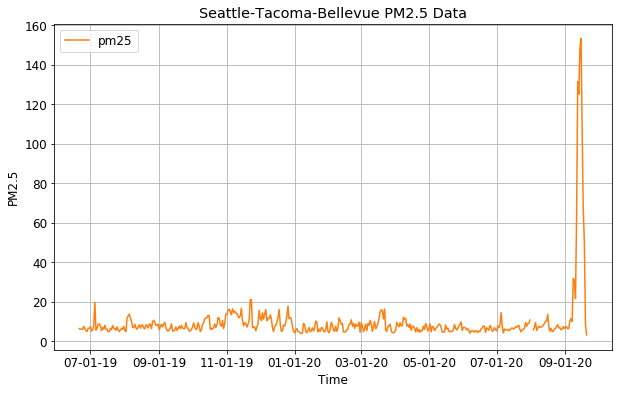

In [18]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(aq_df_resampled.index, aq_df_resampled.value, color='tab:orange', label='pm25')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('PM2.5')
ax.set_title(f"{city} PM2.5 Data")
ax.grid(True)
ax.legend(loc='upper left')
ax.xaxis.set_major_formatter(DateFormatter('%m-%d-%y'))